# Spatialdata - A quick introduction 

This tutorial provides a quick overview over key functionalities of the spatialdata format. This includes 

1. data loading storage and loading
2. alignment of modalities,
3. plotting, and 
4. visualization in napari image viewers. 

For detailed explanations and tutorials, check out the official [documentation](https://spatialdata.scverse.org/en/latest/index.html) 


## What is spatialdata? 

Spatialdata is a data framework for the joint and accessible storage of imaging data, annotations, and -omics data. This is extremely useful for spatialomics experiments, that commonly generate imaging data and (partially) paired -omics measurements. 

### Yet another dataformat? 
The power of spatialdata comes from the fact that it was designed from the start as integrated format of -omics and imaging data. The spatialdata format implements FAIR principles following (future versions of) the OME-Zarr storage/disk format. It further provides many convenient functionalities, including the overlay of imaging data and -omics measurements as static plots or in dynamic viewers (Napari), interfaces with -omics analysis tools, and deep learning frameworks. Spatialdata is performant and can handle large imaging, and -omics data, as well as complex annotations. 

Most notably, spatialdata makes it simple to keep track of cells or shapes of interest between modalities (imaging, annotation, -omics) 

It should be expected that spatialdata will become the de-facto standard for the analysis of spatial -omics data in the following years, at least in the Python ecosystem.  

### Spatialdata and the DVP workflow 
Spatialdata implements key functionalities that are relevant in the DVP workflow. 

A typical DVP workflow might be outlined in the following. Note that spatialdata implements storage options for any step of the workflow and thus helps to keep track between modalities.  

\# | Step | Modality | Format | Spatial Element
--- | --- | --- | --- | --- 
1 | Immunofluorescence/Pathology staining | Imaging | `.czi`, `.mrxs`, `.tiff` | `.images` 
2 | Cell segmentation | Annotation | cellpose, ... (e.g. `.tiff`) | `.shapes` vectors, `.labels` raster data
3 | Selection of cells | Annotation/Featurization | scPortrait (`diverse`) | `.tables` | 
4 | Excision of cells | - | pyLMD (`.xml`) | - |
5 | MS measurement | omics | alphaDIA, alphabase, DIANN (`diverse`) | `.tables` |


## Getting started

In the following, we will just explore the spatialdata format a little more. Note that you should also checkout the official documentation [documentation](https://spatialdata.scverse.org/en/latest/index.html), and especially the tutorials on the spatialdata format

- [Tutorial 1](https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks/examples/models1.html)

 and  spatialelements

- [Tutorial 2](https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks/examples/models2.html)

## Modules

In [1]:
import spatialdata as sd

/Users/lucas-diedrich/anaconda3/envs/dvpio/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## Data

Let's get a built-in mock dataset from spatialdata

In [2]:
sdata = sd.datasets.blobs(extra_coord_system="second_coordinate_system")

/Users/lucas-diedrich/anaconda3/envs/dvpio/lib/python3.12/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/lucas-diedrich/anaconda3/envs/dvpio/lib/python3.12/site-packages/spatialdata/models/models.py:1048: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)


Let's explore the structure of the spatialdata object. You can see that the dataset contains multiple attributes 

In [3]:
sdata

SpatialData object
├── Images
│     ├── 'blobs_image': DataArray[cyx] (3, 512, 512)
│     └── 'blobs_multiscale_image': DataTree[cyx] (3, 512, 512), (3, 256, 256), (3, 128, 128)
├── Labels
│     ├── 'blobs_labels': DataArray[yx] (512, 512)
│     └── 'blobs_multiscale_labels': DataTree[yx] (512, 512), (256, 256), (128, 128)
├── Points
│     └── 'blobs_points': DataFrame with shape: (<Delayed>, 4) (2D points)
├── Shapes
│     ├── 'blobs_circles': GeoDataFrame shape: (5, 2) (2D shapes)
│     ├── 'blobs_multipolygons': GeoDataFrame shape: (2, 1) (2D shapes)
│     └── 'blobs_polygons': GeoDataFrame shape: (5, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (26, 3)
with coordinate systems:
    ▸ 'global', with elements:
        blobs_image (Images), blobs_multiscale_image (Images), blobs_labels (Labels), blobs_multiscale_labels (Labels), blobs_points (Points), blobs_circles (Shapes), blobs_multipolygons (Shapes), blobs_polygons (Shapes)
    ▸ 'second_coordinate_system', with elements:
 

## Access attributes
You can access these attributes as class attributes (output hidden)

In [38]:
%%capture
# Access `images`
sdata.images

Their contents behave like a dictionary (output hidden)

In [39]:
%%capture
# Access the `blobs_image` layer in `.images`
sdata.images["blobs_image"]

## Images
Images are stored as `xarray.DataArrays` (or, in case of pyramidal/multiscale images as `xarray.DataTree`). `xarray` supports the *lazy loading* of data via its `dask` interface, i.e. it only loads the parts of the image that are required for your computations. This allows users to store image data that is significanly larger than their memory.

<!-- The `xarray` builds on NumPy and Pandas, but adds adds support for annotated indexes etc., making it especially useful for scientific and data-intensive applications. It works seamlessly with Dask for parallel and out-of-core computations, making it scalable for large datasets. -->

In [8]:
type(sdata.images["blobs_image"])

xarray.core.dataarray.DataArray

Images have the dimensions $(c, y, x)$, where $c$ is the number of channels (e.g $c=3$ for RGB images, $c=C$ for $C$ different fluorescence channels), $y$ the number of rows, and $x$ the number of columns. 

In [9]:
sdata.images["blobs_image"]

<xarray.DataArray 'image' (c: 3, y: 512, x: 512)> Size: 6MB
dask.array<array, shape=(3, 512, 512), dtype=float64, chunksize=(3, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 24B 0 1 2
  * y        (y) float64 4kB 0.5 1.5 2.5 3.5 4.5 ... 508.5 509.5 510.5 511.5
  * x        (x) float64 4kB 0.5 1.5 2.5 3.5 4.5 ... 508.5 509.5 510.5 511.5
Attributes:
    transform:  {'global': Identity , 'second_coordinate_system': Identity }

#### Visualise
Let's plot the image

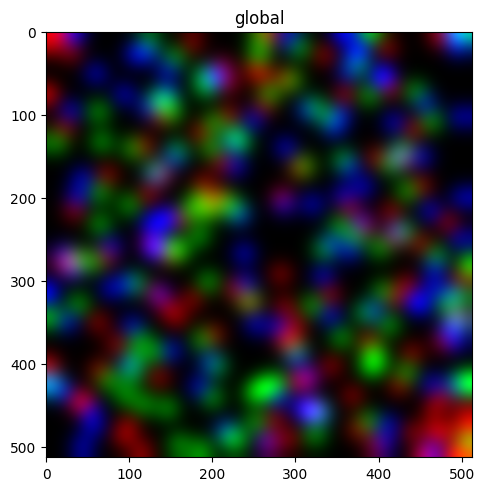

In [7]:
sdata.pl.render_images("blobs_image").pl.show(coordinate_systems="global")

## Shapes

Shapes represent vectorized annotations. This means that each shape is defined as a set of points in a coordinate space. For example to define a small triangle as vectorized shape, you would define it with 4 points (3 unique points and 1 point to close the loop):

(Pseudocode)
```None
triangle := {
    Point1(0, 0), 
    Point2(1, 0),
    Point3(0, 1),
    Point4(0, 0)
    }
```

Spatialdata stores such vectorized annotations in its `.shapes` attribute. The shapes attribute can store different types of shapes, including Polygons (arbitrary shapes) and Points. The shapes attribute can store multiple distinct and independent spatial elements. 

In [45]:
# Access shapes (3 independent elements: 'blobs_circles', 'blobs_polygons', 'blobs_multipolygons')
list(sdata.shapes.keys())

['blobs_circles', 'blobs_polygons', 'blobs_multipolygons']

Each spatialelement is represented as `geopandas.GeoDataFrame`

In [42]:
sdata.shapes["blobs_polygons"]

,geometry
0,"POLYGON ((340.197 258.214, 316.177 197.065, 29..."
1,"POLYGON ((284.141 420.454, 267.249 371.319, 25..."
2,"POLYGON ((203.195 229.528, 285.506 204.414, 19..."
3,"POLYGON ((240.46 196.846, 227.206 188.623, 149..."
4,"POLYGON ((446.703 349.433, 421.086 258.9, 369...."


Let's plot the data 

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


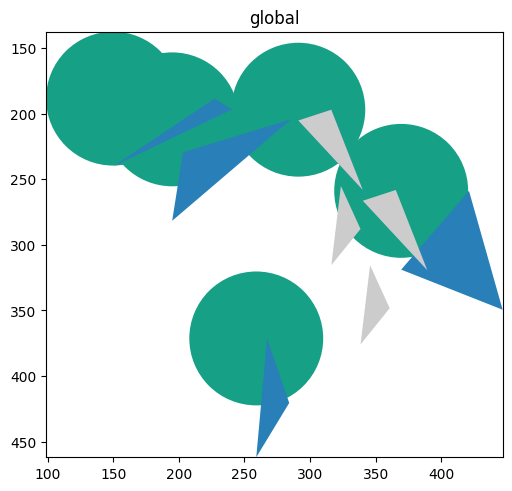

In [50]:
(
    sdata.pl.render_shapes("blobs_circles", alpha=0.5, color="#16A085")  # green
    .pl.render_shapes("blobs_polygons", alpha=0.5, color="#2980B9")  # blue
    .pl.render_shapes("blobs_multipolygons", alpha=0.5, color="#cccccc")  # gray
    .pl.show(coordinate_systems="global")
)

#### Background - Shapes representation in spatialdata

##### shapely

spatialdata uses [`shapely`](https://shapely.readthedocs.io/en/stable/) to define the shapes. We can define our own shape

In [10]:
import shapely

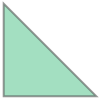

In [11]:
triangle = shapely.Polygon([[0, 0], [1, 0], [0, 1], [0, 0]])
triangle

##### Geopandas 
Spatialdata stores multiple shape annotations as [`geopandas.GeoDataFrame`](https://geopandas.org). 

`geopandas.GeoDataFrame`s behave exactly like a pandas dataframe, except that they support spatial data in a designated `geopandas.GeoSeries` column (usually denoted with `geometry`)
 
We can add the previously defined shape to a geopandas dataframe:

In [13]:
import geopandas as gpd

In [18]:
geodf = gpd.GeoDataFrame(data={"name": ["triangle", "triangle2"]}, geometry=[triangle, triangle])
geodf

,name,geometry
0,triangle,"POLYGON ((0 0, 1 0, 0 1, 0 0))"
1,triangle2,"POLYGON ((0 0, 1 0, 0 1, 0 0))"


In [22]:
# Geopandas behaves like pandas. E.g. Select the first row in the geodataframe
geodf.iloc[[0]]

,name,geometry
0,triangle,"POLYGON ((0 0, 1 0, 0 1, 0 0))"


### Tables 

Tables are used in spatialdata to store omics modalities. Under the hood, tables are represented by an [`anndata`](https://anndata.readthedocs.io) object. Anndata is commonly used to store -omics data as it provides functionalities to jointly anlayse the actual measurements and associated metadata. 

#### !!! Tables support by DVP IO 
DVP IO does currently not provide reading functionalities for proteomics data. This feature will be introduced in early 2025

In [ ]:
sdata.tables["table"]

AnnData object with n_obs × n_vars = 26 × 3
    obs: 'instance_id', 'region'
    uns: 'spatialdata_attrs'

Get observation-specific metadata 

In [55]:
adata = sdata.tables["table"]

adata.obs.head()

,instance_id,region
1,1,blobs_labels
2,2,blobs_labels
3,3,blobs_labels
4,4,blobs_labels
5,5,blobs_labels


Get variable-specific metadata

In [56]:
adata.var.head()

""
channel_0_sum
channel_1_sum
channel_2_sum
